In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [15]:
np.random.seed(32)
class Maze(object):
    """
    Clase para representar un laberinto y la posicion del robot dentro del mismo
    """
    
    def __init__(self, matrix_maze: np.ndarray):
        assert len(matrix_maze.shape) == 2,'La matriz debe tener 2 dimensiones'
        assert np.isin(matrix_maze, [0,1]).all(), 'La matriz debe tener solo 0 o 1 como valores'
        self.X, self.Y = matrix_maze.shape
        self.grid = matrix_maze
        self.tiles_list = self.__init_tiles_list__()
        self.O = np.zeros((len(self.tiles_list), len(self.tiles_list))) # emission matrix
        self.T = self.__calculate_transition_matrix__()
        self.a_path = []
        self.acc_f = []
        self.arr_err = []
        self.arr_acc = []

    def __init_tiles_list__(self):
        '''
        Retorna una lista con las posiciones de las celdas disponibes ara desplazarse.
            Parameters:
                    None
            Returns:
                    (list): Lista de tuplas con las posiciones disponibles
        '''
        r,c = np.where(self.grid == 1)
        return [(x,y) for x,y in zip(r,c)]

    def __calculate_transition_matrix__(self):
        '''
        Retorna una matriz con las probablidades de transicion entre las distintas celdas disponibles.
            Parameters:
                    None
            Returns:
                    (matrix): Matriz con las probabilidades de transicion.
        '''
        T = np.zeros((len(self.tiles_list),len(self.tiles_list)))
        for i, tile in enumerate(self.tiles_list):
            (x,y)=tile
            neigh=self.__get_neighbours__(x,y)
            Ns=len(neigh)
            for j in range(Ns):
                index=self.tiles_list.index(neigh[j])
                T[i][index]=1/Ns
        return T
        
    def __get_neighbours__(self, x,y):
        '''
        Retorna una lista con los vecinos de una celda.
            Parameters:
                    x: Posicion X de la celda
                    y: Posicion Y de la celda
            Returns:
                    (list): Lista de tuplas de las posiciones (X,Y) con los posibles vecinos disponibles de una celda.
        '''
        a_list = []
        clip_vals = lambda x1,y1: [x1,y1] if (0 <= x1 < self.X) and (0 <= y1 < self.Y) else None
        for dirr in [clip_vals(x-1, y), clip_vals(x, y+1), clip_vals(x+1, y), clip_vals(x, y-1)]:
            if dirr and self.grid[x,y] and self.grid[dirr[0], dirr[1]]: 
                a_list.append((dirr[0], dirr[1]))
        return a_list
    
    def HMM(self, epsilon, iterate):
        '''
        Metodo que realiza la simulacion de la estimacion de la posicion del robot usando un modelo oculto de Markov.
            Parameters:
                    epsilon: Error porcentual en la medicion de los sensores del robot
                    iterate: Cantidad de interaciones que la simulacion realiza
            Returns:
                    None
        '''
        size = len(self.tiles_list)
        arr_err = []
        arr_acc = []
        e_path = []
        a_path = []
        acc_f = []
        f = np.full((size, 1),1/size) #prior
        m = np.full((size, 1),1/size)
        while(True):
            (a,b)=self.tiles_list[np.random.choice(len(self.tiles_list))]
            if self.__get_neighbours__(a,b):
                break;
        
        for k in range(iterate):
            self.__sensor_model__(a,b,epsilon)  # calculate O matrix 
            
            f=self.__filtering__(f)             #find posterior
            acc_f.append(f)
            ind=np.argmax(f)
            x,y=self.tiles_list[ind]
            
            arr_err.append(abs(a-x)+abs(b-y));
            m,z=self.__viterbi__(m)
            e_path.append(self.tiles_list[z])
            a_path.append((a,b))
            acc=self.__path_acc__(e_path,a_path)
            arr_acc.append(acc)
            
            N=self.__get_neighbours__(a,b)
            Nind=np.random.randint(0,len(N), size=None)
            (a,b)=N[Nind]
        self.a_path, self.acc_f, self.arr_err, self.arr_acc = a_path, acc_f, arr_err, arr_acc
    
    def plot_error_accuracy(self):
        '''
        Metodo que imprime la precision y error en la ubicacion del robot.
            Parameters:
                    None
            Returns:
                    Figura con el comportamiento del error
        '''
        fig, axs = plt.subplots(1,2,figsize=(12, 4))
        axs[0].set_title('Error')
        axs[0].set(xlabel='Number of Observations', ylabel='Localization error')
        axs[0].plot(self.arr_err)
        
        axs[1].set_title('Accuracy')
        axs[1].set(xlabel='Number of Observations', ylabel='Path Accuracy')
        axs[1].plot(self.arr_acc)
        plt.show()
    
    def plot_position(self, steps):
        '''
        Metodo que imprime la posicion estmada y actual del robot, asi como las probabilidades.
            Parameters:
                    None
            Returns:
                    Figura con la distribucion de probabilidad de la ubicacion
        '''
        fig = plt.figure(figsize=(10, 5*int(np.ceil(steps/2)) ))
        limit = min(steps, len(self.a_path))
        for idx in range(limit):
            z=[]
            y=[]
            x=[]
            ax1 = fig.add_subplot(int(np.ceil(steps/2)),2,idx+1, projection='3d')
            ax1.set_title(f'Paso {idx+1} de {limit}')
            width = depth = 1
            data = self.acc_f[idx].ravel()
            for val, tile in zip(data*(1.0/data.max()), self.tiles_list):
                if val:
                    x.append(tile[0])
                    y.append(tile[1])
                    z.append(val)
            bottom = np.zeros_like(x)
            
            ax1.bar3d(x, y, bottom, width, depth, z, shade=True, color=(0, 0, 1, 0.4))
            ax1.bar3d(self.a_path[idx][0], self.a_path[idx][1], 0, width, depth, 0.5, shade=True, color='C1')
            #plt.savefig(f'out/{idx}.png')
        plt.show()

        
    def __sensor_model__(self, x,y,epsilon):
        '''
        Metodo que calcula la matriz de emision a partir de la lectura de los sensores.
            Parameters:
                    x: Posicion X del robot
                    y: Posicion Y del robot
                    epsilon: Error porcentual en la medicion de los sensores del robot
            Returns:
                    (matrix): Matriz con las probabilidades de emision del estado actual
        '''
        read = self.__sensor_reading__(x,y)
        for i, tile in enumerate(self.tiles_list):
            (a,b)=tile
            A=self.__sensor_reading__(a,b)
            dit=self.__error__(A,read)
            t=np.power(1-epsilon,4-dit)*np.power(epsilon,dit)
            self.O[i][i]=t;

    def __sensor_reading__(self, x,y):
        '''
        Metodo que retorna la medicion de los sensores a partir de la posicion actual.
            Parameters:
                    x: Posicion X del robot
                    y: Posicion Y del robot
            Returns:
                    (list): Lista con las mediciones de los sensores (1) espacio disponible, (0) muro o espacio no disponible
        '''
        reading=list("1111")
        if x-1<0 or self.grid[x-1][y]==0:
            reading[0]="0"
        if x+1>=self.X or self.grid[x+1][y]==0:
            reading[1]="0"
        if y+1>=self.Y or self.grid[x][y+1]==0:
            reading[2]="0"
        if y-1<0 or self.grid[x][y-1]==0:
            reading[3]="0"
        return reading

    def __error__(self, A,R):
        '''
        Metodo que retorna la cantidad de discrepancias entre la posicion actual y estimadas del robot.
            Parameters:
                    A: Tupla con la posicion actual del robot
                    R: Tupla con la posicion estimada del robot
            Returns:
                    (number): Numero de discrepancias en la medicion de los sensores entre las 2 posiciones
        '''
        return np.sum([0 if x==y else 1 for x,y in zip(A,R)])

    def __filtering__(self, f):
        '''
        Metodo que realiza el filtering para estimar la posicion actual basado en la posicion estimada anterior.
            Parameters:
                    f: Vector con la distribucion de probabildad de la posicion actual del robot
            Returns:
                    (vector): Vector con el proceso de filtrado
        '''
        return np.matmul(self.O,np.matmul(np.transpose(self.T),f))

    def __viterbi__(self, m):
        '''
        Metodo que realiza el algoritmo de Viterbi para estimar la ruta mas aproximada a la real.
            Parameters:
                    m: Vector con la distribucion de probabildad de la posicion actual del robot
            Returns:
                    (vector): Vector con la ruta aproximada
                    (number): Posicion actual estimada del robot
        '''
        g=np.multiply(np.transpose(self.T),np.transpose(m))
        t=np.amax(g,axis=1)
        m=np.matmul(self.O,t)
        max_ind=np.argmax(m)
        return m,max_ind

    def __path_acc__(self, e_path, a_path):
        '''
        Metodo que realiza el algoritmo de Viterbi para estimar la ruta mas aproximada a la real.
            Parameters:
                    e_path: Lista de tuplas con la posicion estimada del robot
                    a_path: Lista de tuplas con la posicion real del robot
            Returns:
                    (number): Porcentaje de error entre la dos rutas
        '''
        return np.sum([0 if x==y else 1 for x,y in zip(e_path,a_path)]) / len(e_path)

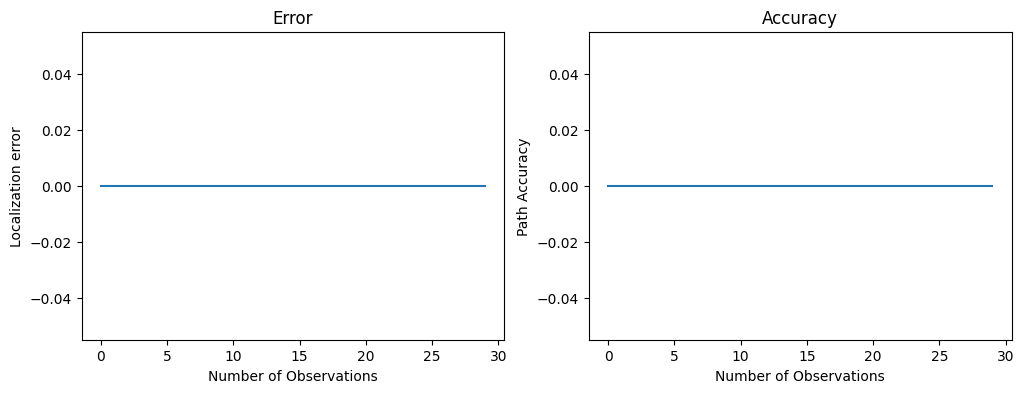

In [16]:
matrix_maze = [[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1],
               [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0],
               [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1],
               [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
m = Maze(np.array(matrix_maze))
m.HMM(0.05, 30)
m.plot_error_accuracy()

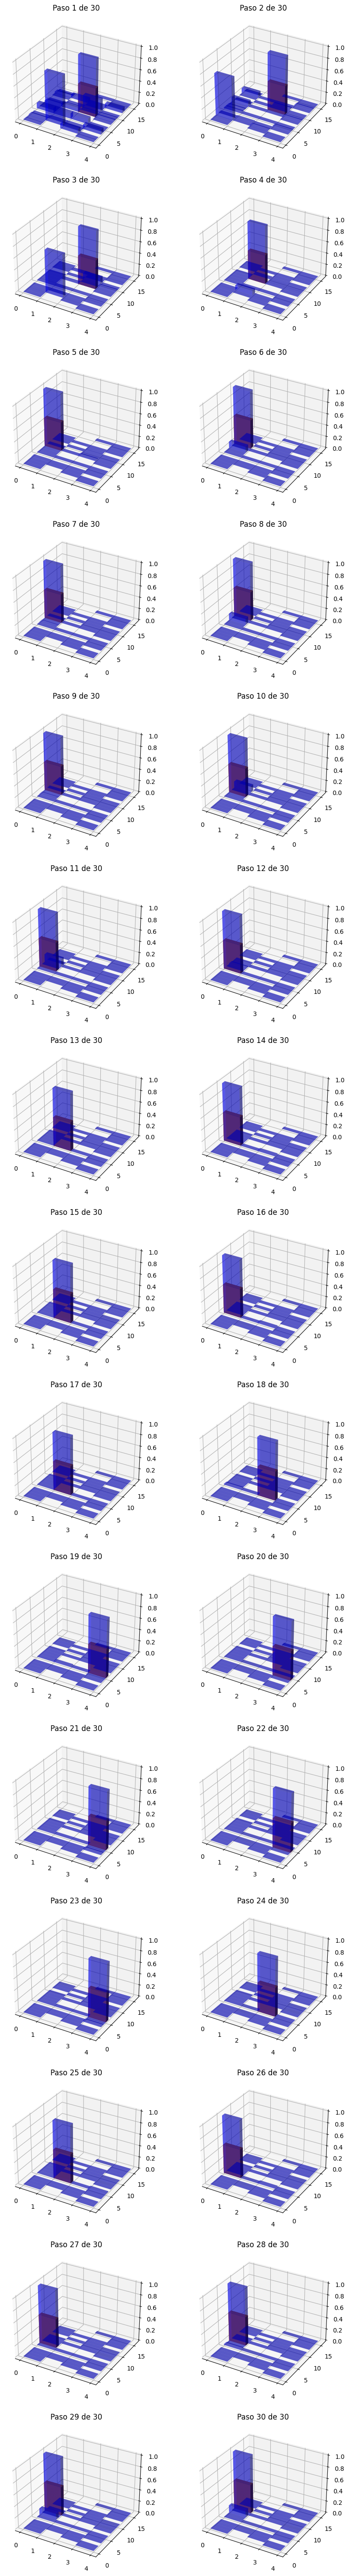

In [14]:
m.plot_position(30)